## Introduction 

In this notebook, we will train and tune a xgboost classification model. The goal is to predict which of the transactions are fraudulent based on some numerical features. Since the dataset is highly imbalanced, we will use the *area under the precision recall curve* as the main metric to evaulate the quality of the models. 

The hyperparameter tuning will be performed through Bayesian optimization via the `BoTorchSampler` API in optuna. This API requires the `botorch` library to be installed.

In [1]:
!pip install botorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.8/567.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 14.0 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc

import optuna
from optuna.integration.botorch import BoTorchSampler, qei_candidates_func
import joblib

from typing import Tuple, Optional, Dict

plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi': 150})


## Loading the data

In [3]:
raw_df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
print(f'Number of observations: {raw_df.shape[0]}')

Number of observations: 284807


In [5]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print(f'Number of fraudulent entries: {pos} ({pos / total * 100:.3f}% of total)')

Number of fraudulent entries: 492 (0.173% of total)


## Splitting the data

To test the models, we will be split the raw data into training and test sets using a 80-20 split with stratification on the class labels. The test set will be used only for testing the quality of the final model, and it will not be used for hyperparameter tuning.

In [6]:
train_df, test_df = train_test_split(raw_df, test_size=0.2, random_state=1, stratify=raw_df['Class'])

In [7]:
# labels
y = train_df['Class'].values
y_test = test_df['Class'].values

for tag, labels in zip(['training', 'test'], [y, y_test]):
    print(f'Percentage of positive class observations in {tag} set: {labels.mean()*100:.3f}')


Percentage of positive class observations in training set: 0.173
Percentage of positive class observations in test set: 0.172


In [8]:
# get the X's (TODO: transforms)
X = train_df.drop('Class', axis=1)
X_test = test_df.drop('Class', axis=1)

## XGBoost model

The function `fit_model` in the cell below trains a xgboost classifier. The function allows the specification of hyperparameters as a dictionary through the `config` argument. If `config` is not specified, default values of the hyperparameters are used.

In [9]:
def fit_model(
    X:pd.DataFrame,
    y:np.ndarray,
    config:Optional[Dict]=None,
    n_jobs:int=1
) -> XGBClassifier:
    '''
    Trains a xgboost classifer on the data
    '''
    
    model = XGBClassifier(n_jobs = n_jobs, tree_method='hist')
    
    if config:
        model.set_params(**config)
        
    return model.fit(X, y)

## Tuning hyperparameters through Optuna

We will tune the hyperparameters to maximize the  stratified 5-fold CV estimate for the area under the precision-recall curve.

In [10]:
def auc_pr(y_true, y_score) -> float:
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    return auc(recall, precision)

In [11]:
import warnings
def fit_and_test_fold(X:pd.DataFrame, y:np.ndarray, config:Dict, train_index:np.ndarray, val_index:np.ndarray) -> float:
    # split the data into training and validation splits
    X_train, X_val = X.iloc[train_index,:], X.iloc[val_index,:]
    y_train = y[train_index]; y_val = y[val_index]
    
    # fit model on the training split
    model = fit_model(X_train, y_train, config, n_jobs=4)
    
    # generate predictions on validation split
    y_val_prob = model.predict_proba(X_val)[:, 1]
    
    # return the auc on the validation split
    return auc_pr(y_val, y_val_prob)


def optuna_objective(trial):
    
    config = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.75, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 12, log=True),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 100, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 100, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 100, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, neg / pos, log=True)
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    cv_auc_scores = []
    for train_index, val_index in cv.split(X, y):
        cv_auc_scores.append(
            fit_and_test_fold(X, y, config, train_index, val_index)
        )
    
    # saving the individual fold holdout losses 
    # uncomment this line if you don't want this
    trial.set_user_attr('fold_scores', cv_auc_scores)
        
    return np.mean(cv_auc_scores)

warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning, module='optuna.integration')
# define sampler and trial

sampler = BoTorchSampler(
    n_startup_trials=10,# recommended minimum: max(5,1+no_of_hyperparameters)
    seed=123
)

study = optuna.create_study(sampler=sampler, directions=['maximize'], study_name='xgboost')

# run the study - maximum of 100 trials or 1800sec wall-clock time
study.optimize(optuna_objective, n_trials=100, timeout=1800)

# save the runs
_ = joblib.dump(study, 'xgboost_hyperopt_fraud.pkl')

/tmp/ipykernel_20/1027815319.py:47: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
  sampler = BoTorchSampler(
[I 2023-10-31 04:00:23,601] A new study created in memory with name: xgboost
[I 2023-10-31 04:00:47,222] Trial 0 finished with value: 0.7129327841842938 and parameters: {'n_estimators': 402, 'learning_rate': 0.0012847169462887496, 'max_depth': 1, 'subsample': 0.5961832921746021, 'colsample_bytree': 0.7475220728070068, 'reg_alpha': 0.00017024117230719408, 'reg_lambda': 64.21581278784039, 'gamma': 0.07051757771805378, 'scale_pos_weight': 21.293860251341325}. Best is trial 0 with value: 0.7129327841842938.
[I 2023-10-31 04:00:59,014] Trial 1 finished with value: 0.7622316177829072 and parameters: {'n_estimators': 161, 'learning_rate': 0.0021371540932817725, 'max_depth': 5, 'subsample': 0.494715020211662, 'colsample_bytree': 0.15371010694861154, 'reg_alpha': 9.559662353571618e-05, 'reg_lambda': 0.239857916727318

In [12]:
# summarize results
results = study.trials_dataframe(attrs=('number','value', 'duration', 'params'))
results = results.rename(columns={'value':'auc_pr'})
results['duration'] = results['duration']/np.timedelta64(1, 's')
results = results.sort_values(by='auc_pr',ascending=False)
results.to_csv('cv_auc_pr_history.csv',index=False)
# print the top 10 results
results.head(10)

,number,auc_pr,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_depth,params_n_estimators,params_reg_alpha,params_reg_lambda,params_scale_pos_weight,params_subsample
33,33,0.856214,36.005268,0.608687,0.000537,0.093548,12,230,1.469967e-05,1.642349e-07,105.134669,0.599318
52,52,0.856034,29.417917,0.589461,0.000038,0.051690,12,207,2.971884e-04,1.445232e-06,13.880058,0.715677
40,40,0.855736,36.984444,0.571925,0.002187,0.053236,12,247,2.246529e-05,2.727223e-07,70.784797,0.702379
51,51,0.855586,37.229996,0.673255,0.000079,0.059578,12,252,9.067750e-03,1.735474e-06,37.222572,0.596101
43,43,0.855556,33.102077,0.662391,0.000004,0.096324,12,219,3.623670e-05,1.622275e-07,70.042091,0.712222
55,55,0.854400,37.931911,0.486956,0.000069,0.074117,12,192,9.744576e-05,2.319193e-05,577.876016,0.720659
36,36,0.854391,34.995710,0.528618,0.000046,0.082888,7,234,1.236158e-08,1.065615e-05,125.428736,0.609396
39,39,0.854164,35.504418,0.500403,0.000011,0.058312,12,207,5.661906e-06,8.214892e-05,142.010756,0.637165
37,37,0.854094,35.610333,0.639829,0.000070,0.096651,11,214,6.013261e-07,1.489709e-05,387.002499,0.788861
60,60,0.853839,38.357784,0.579086,0.000088,0.089225,12,228,1.892452e-04,4.119967e-07,302.300661,0.704081


### Visualizing optuna trials

Optuna has some tools for visualizing the optimization progress, as well as assessing the importance of the individual hyperparameters on the cross-validation objective (see https://optuna.readthedocs.io/en/stable/reference/generated/optuna.importance.FanovaImportanceEvaluator.html and http://proceedings.mlr.press/v32/hutter14.html for more details). 

In [13]:
from optuna.visualization import plot_optimization_history, plot_param_importances

In [14]:
fig = plot_optimization_history(study, target_name='AUC-PR')

fig.update_layout(
    autosize=True,
    width=800,
    height=600
)
fig.show()

In [15]:
# TODO: verify if these can be trusted for a small number of trials
fig = plot_param_importances(study)

fig.update_layout(
    autosize=True,
    width=800,
    height=600
)
fig.show()

## Final model

In [16]:
model = fit_model(X, y, study.best_params, n_jobs=4)
model.save_model('xgboost_fraud.json')

## Evaulate on test set

In [17]:
test_pred_prob = model.predict_proba(X_test)[:, 1]
test_auc_pr = auc_pr(y_test, test_pred_prob)
print(f'Area under PR curve for test set: {test_auc_pr:.3f}')

Area under PR curve for test set: 0.905


### Precision-recall curves

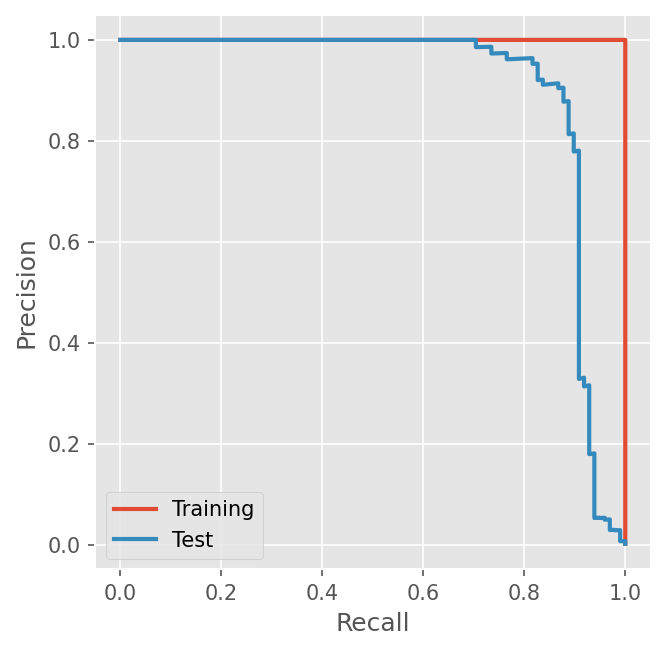

In [18]:
train_pred_prob = model.predict_proba(X)[:, 1]

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)

    plt.plot(recall, precision, label=name, linewidth=2, **kwargs)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Training", y, train_pred_prob)
plot_prc("Test", y_test, test_pred_prob)
plt.legend(loc='lower left');

### Confusion matrix

Finally, we evaulate the confusion matrix on the test set to generate the classes. The threshold should be chosen carefully depending on the business needs. For example, not identifying a fradulent transaction is typically considered more costly than raising a false alarm - the loss can also include other fraudulent transactions carried out on the compromised card.

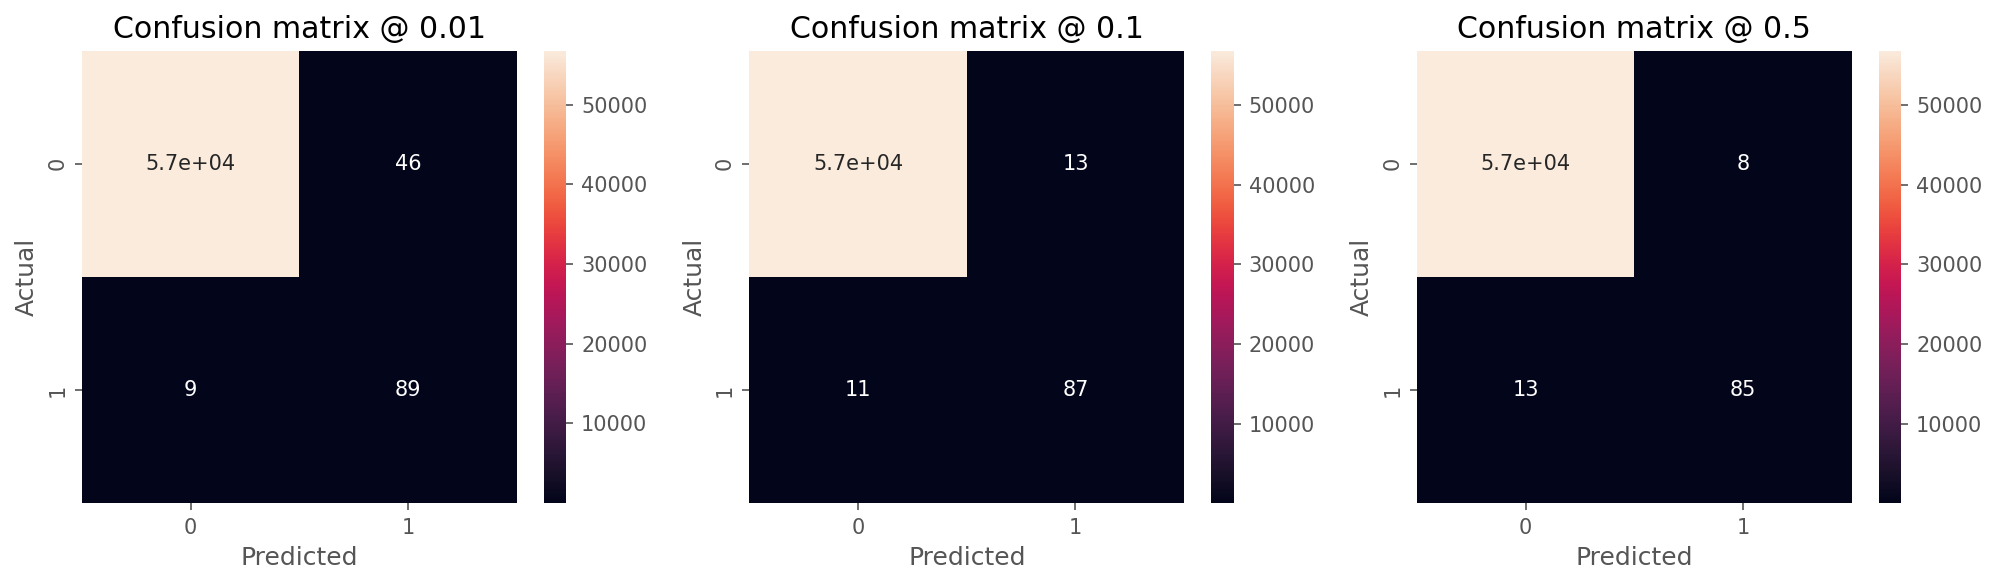

In [19]:
thresholds = [0.01, 0.1, 0.5]

fig, axs = plt.subplots(1, len(thresholds), figsize=(4.5*len(thresholds), 4))
for i, threshold in enumerate(thresholds):
    _ = sns.heatmap(confusion_matrix(y_test, test_pred_prob > threshold), annot=True, ax=axs[i])
    _ = axs[i].set_ylabel('Actual')
    _ = axs[i].set_xlabel('Predicted')
    _ = axs[i].set_title(f'Confusion matrix @ {threshold}')
    
fig.tight_layout()

